In [18]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Deprecation and Incorrect Usage Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Expand cell and pandas width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# Read Data

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
test  = pd.read_csv('data/test.csv',  parse_dates=['datetime'])

print(train.shape, test.shape)

(10886, 12) (6493, 9)


# Feature Engineering

In [3]:
def split_date(dt):
    dt['year'] = dt['datetime'].dt.year
    dt['month'] = dt['datetime'].dt.month
    #dt['day'] = dt['datetime'].dt.day
    dt['hour'] = dt['datetime'].dt.hour
    #dt['minute'] = dt['datetime'].dt.minute
    #dt['second'] = dt['datetime'].dt.second
    dt['dayofweek'] = dt['datetime'].dt.dayofweek
    
    return dt

In [4]:
train = split_date(train)
test =split_date(test)

print(train.shape, test.shape)

(10886, 16) (6493, 13)


### `연속형 feature`로 표현된 `범주형 feature`를 `category`로 변경

In [5]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for col in categorical_feature_names:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

### 학습에 사용할 feature들만을 가지고 train/test data를 생성

In [8]:
features = ["season", "weather", "temp", "atemp", "humidity", "year", "hour", "dayofweek", "holiday", "workingday"]
label_name = 'count'

X_train = train[features]
X_test = test[features]

y_train = train[label_name]

print(X_train.shape, X_test.shape, y_train.shape)
X_train.head(3)

(10886, 10) (6493, 10) (10886,)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0


# Scoring에 사용할 RMSLE

In [13]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values)
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

# Linear Regression Model (선형회귀 모델)

- 선형회귀(=최소제곱법) : 가장 간단하고 오래된 회귀용 선형 알고리즘
- 예측과 훈련 세트에 있는 타겟 y 사이의 MSE(평균 제곱오차)를 최소화하는 파라메터 w와 b를 찾는다.
- 매개변수가 없는게 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [14]:
lrm = LinearRegression()

y_train_log = np.log1p(y_train)
lrm.fit(X_train, y_train_log)

preds = lrm.predict(X_train)

print("RMSLE for Linear Resreggion: ", rmsle(np.exp(y_train_log), np.exp(preds), False))


RMSLE for Linear Resreggion:  0.9803697923313502


# Ridge (릿지) - Regularization Model

- 회귀를 위한 선형모델
- 가중치(W)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듬)
- Regularization : overfitting이 되지 않도록 모델을 강제로 제한한다는 의미
- max_iter(반복 실행하는 최대횟수) 설정이 가능

In [19]:
ridge = Ridge()
ridge_params = { 'max_iter': [3000], 'alpha' : [0.01, 0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_ridge = GridSearchCV(ridge, ridge_params, scoring=rmsle_scorer, cv=5)

grid_ridge.fit(X_train, y_train_log)
preds = grid_ridge.predict(X_train)

print(grid_ridge.best_params_)
print("RMSLE for Ridge Regression: ", rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_ridge.grid_scores_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE for Ridge Regression:  0.9803697902780804


,parameters,mean_validation_score,cv_validation_scores
0,"{'alpha': 0.01, 'max_iter': 3000}",-0.987749,"[-1.003137641023443, -0.906726280205338, -1.02..."
1,"{'alpha': 0.1, 'max_iter': 3000}",-0.987749,"[-1.0031402881565283, -0.9067263646533399, -1...."
2,"{'alpha': 1, 'max_iter': 3000}",-0.987756,"[-1.0031667672287898, -0.9067272289039383, -1...."
3,"{'alpha': 2, 'max_iter': 3000}",-0.987764,"[-1.0031962048408585, -0.9067282312574716, -1...."
4,"{'alpha': 3, 'max_iter': 3000}",-0.987771,"[-1.003225659604231, -0.906729277771113, -1.02..."


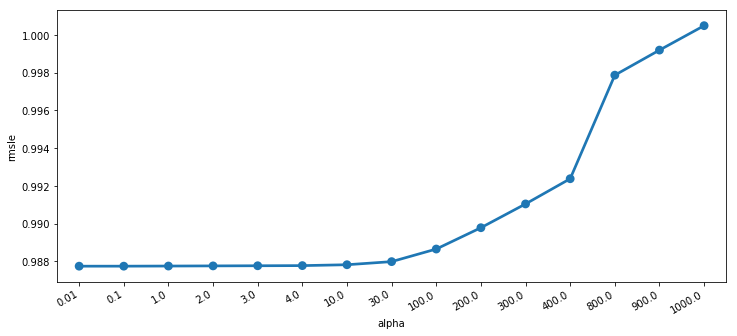

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df['alpha'] = df['parameters'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_validation_score'].apply(lambda x: -x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

# Lasso (라쏘)

- 선형회귀의 Regularization을 적용하는 대안
- 계수를 0에 가깝게 만들려고 하여 이를 L1규제라고 하며, 어떤 계수는 0이 되기도함(완전히 제외하는 feature를 의미)
- feature 선택이 자동으로 이루어진다고도 볼 수 있음
- alpha 값의 기본값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.

In [23]:
lasso = Lasso()

alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = { 'max_iter': [3000], 'alpha' : alpha}

grid_lasso = GridSearchCV(lasso, lasso_params, scoring=rmsle_scorer, cv=5)
grid_lasso.fit(X_train, y_train_log)
preds = grid_lasso.predict(X_train)

print(grid_lasso.best_params_)
print("RMSLE for Lasso: ", rmsle(np.exp(y_train_log), np.exp(preds), False))

df = pd.DataFrame(grid_lasso.grid_scores_)
df.head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE for Lasso:  0.9803727821457643


,parameters,mean_validation_score,cv_validation_scores
0,"{'alpha': 10.0, 'max_iter': 3000}",-1.397134,"[-1.5029884714408925, -1.2764418435331946, -1...."
1,"{'alpha': 1.0, 'max_iter': 3000}",-1.071961,"[-1.2208509459409598, -0.95031831588364, -1.03..."
2,"{'alpha': 0.5, 'max_iter': 3000}",-1.062121,"[-1.186543246069281, -0.9593010075144198, -1.0..."
3,"{'alpha': 0.3333333333333333, 'max_iter': 3000}",-1.060826,"[-1.1765732178094037, -0.9654552266044552, -1...."
4,"{'alpha': 0.25, 'max_iter': 3000}",-1.061149,"[-1.1718729510267891, -0.9690062951847751, -1...."


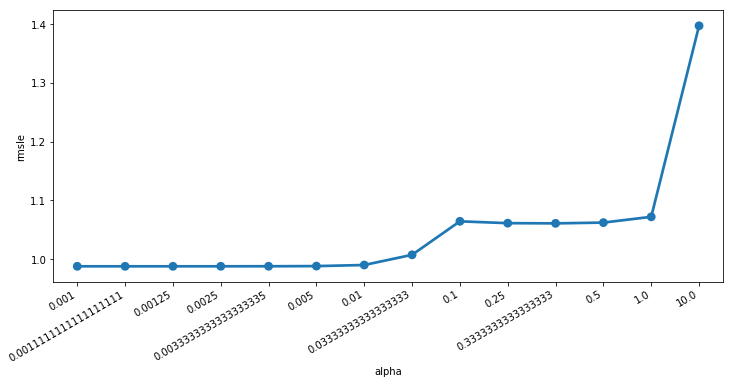

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df['alpha'] = df['parameters'].apply(lambda x: x['alpha'])
df['rmsle'] = df['mean_validation_score'].apply(lambda x: -x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df, x='alpha', y='rmsle', ax=ax)

# Ensemble Models - Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train, y_train_log)
preds = rf.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE for Random Forest: ", score)

RMSLE for Random Forest:  0.10690581410552694


# Ensemble Model - Gradient Boost

- 여러 개의 결정 트리를 묶어 강력한 모델을 만다는 또 다른 앙상블 기법
- 회귀와 분류 모두 사용 가능
- Random Forest와는 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 생성
- 무작위성이 없고 강력한 사전 가지치기가 사용됨
- 1 ~ 5 개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
- learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
- n_estimator 의 값을 키우며 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로잡을 기회가 많아지지만, 너무 크면 모델이 복잡해지고 overfitting이 될 수 있다.
- max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=4000, alpha=0.01)

gb.fit(X_train, y_train_log)
preds = gb.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE for Random Forest: ", score)

RMSLE for Random Forest:  0.2135740372724937


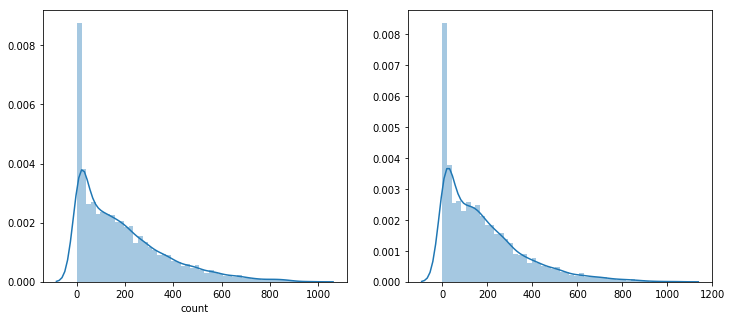

In [28]:
preds_test = gb.predict(X_test)

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(preds_test), ax=ax2, bins=50)

# Submit : Random Forest

In [30]:
rf.fit(X_train, y_train_log)
preds = rf.predict(X_train)

score = rmsle(np.exp(y_train_log), np.exp(preds), False)
score

0.10669210787133684

In [31]:
submission = pd.read_csv('data/sampleSubmission.csv')
submission['count'] = np.exp(rf.predict(X_test))

submission.head()

,datetime,count
0,2011-01-20 00:00:00,13.044707
1,2011-01-20 01:00:00,5.171476
2,2011-01-20 02:00:00,4.000739
3,2011-01-20 03:00:00,4.890629
4,2011-01-20 04:00:00,3.933789


In [32]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)